Dataset: n=130 samples, d=14 parameters (including intercept)
Initial beta (MLE estimate): [  0.433  -9.979  -3.553  -9.16   11.072  -1.491   0.283  -3.226   1.677
   1.614  -2.46    1.011  -5.41  -15.018]
Iter 5000/25000, acc_rate=0.971
Iter 10000/25000, acc_rate=0.963
Iter 15000/25000, acc_rate=0.962
Iter 20000/25000, acc_rate=0.956
Iter 25000/25000, acc_rate=0.952
Metropolis done. Acceptance rate = 0.952. Time = 0.7s
Posterior samples shape: (4000, 14)


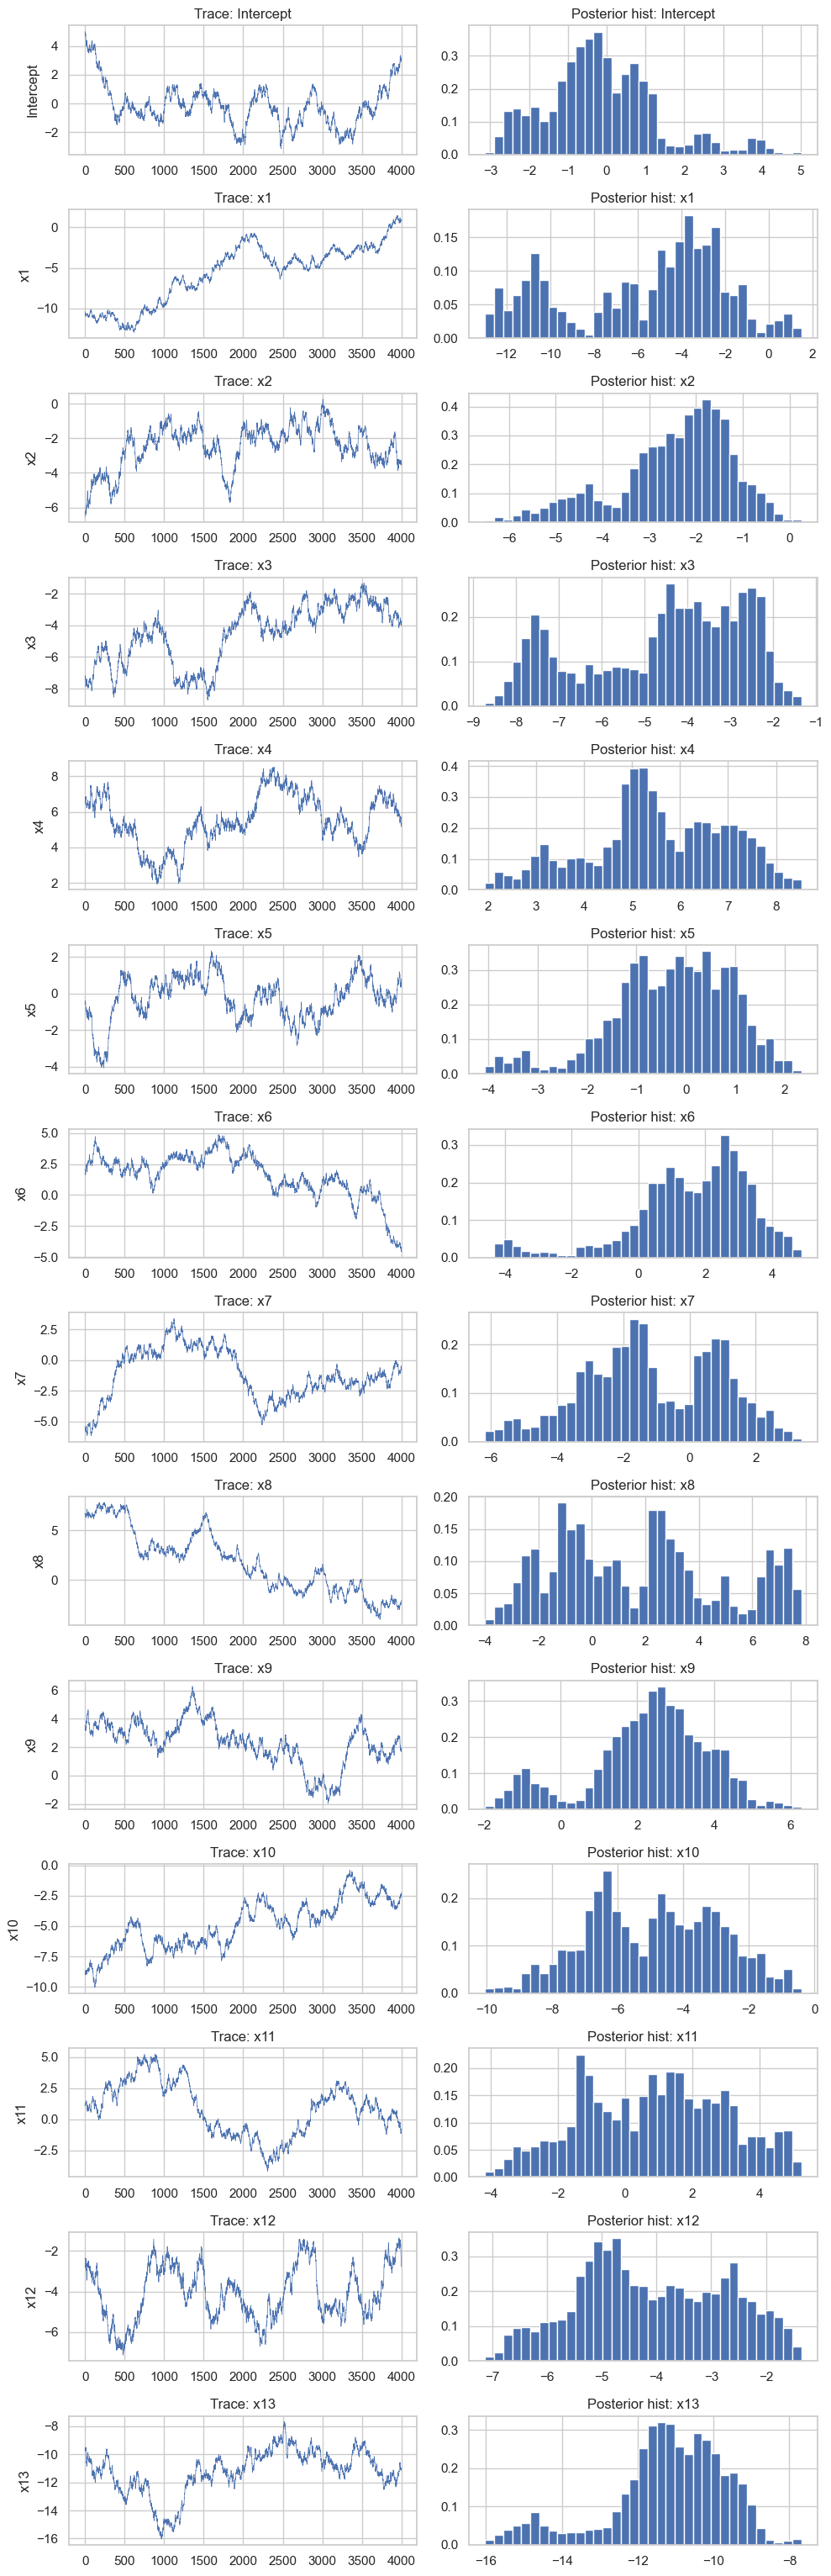


Posterior mean and sd:
        param  post_mean   post_sd
0   Intercept  -0.135516  1.452643
1          x1  -5.653987  3.658619
2          x2  -2.460135  1.232977
3          x3  -4.557170  1.860588
4          x4   5.515782  1.439649
5          x5  -0.292940  1.212944
6          x6   1.568864  1.802969
7          x7  -1.159448  2.032704
8          x8   1.799511  3.128362
9          x9   2.301435  1.568341
10        x10  -4.915732  1.999172
11        x11   0.851158  2.139242
12        x12  -4.086922  1.340147
13        x13 -11.238910  1.577045

Deterministic prediction accuracy using posterior-mean beta: 1.000
Mean predictive accuracy over 200 posterior draws: 0.995 (sd 0.006)


C:\Users\HomePC\AppData\Local\Temp\ipykernel_21800\3879358088.py:159: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(prob_mean[y==0], label="class 0 probs (post-mean)", shade=True)
C:\Users\HomePC\AppData\Local\Temp\ipykernel_21800\3879358088.py:160: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(prob_mean[y==1], label="class 1 probs (post-mean)", shade=True)


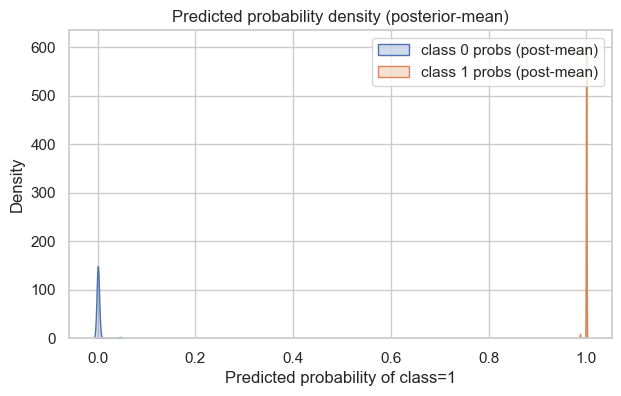


Classical MLE (sklearn) accuracy: 1.0

MLE vs Posterior-mean comparison:
        param  beta_mle  beta_post_mean  post_sd
0   Intercept    0.4326         -0.1355   1.4526
1          x1   -9.9795         -5.6540   3.6586
2          x2   -3.5533         -2.4601   1.2330
3          x3   -9.1601         -4.5572   1.8606
4          x4   11.0724          5.5158   1.4396
5          x5   -1.4909         -0.2929   1.2129
6          x6    0.2831          1.5689   1.8030
7          x7   -3.2262         -1.1594   2.0327
8          x8    1.6768          1.7995   3.1284
9          x9    1.6141          2.3014   1.5683
10        x10   -2.4603         -4.9157   1.9992
11        x11    1.0114          0.8512   2.1392
12        x12   -5.4103         -4.0869   1.3401
13        x13  -15.0183        -11.2389   1.5770


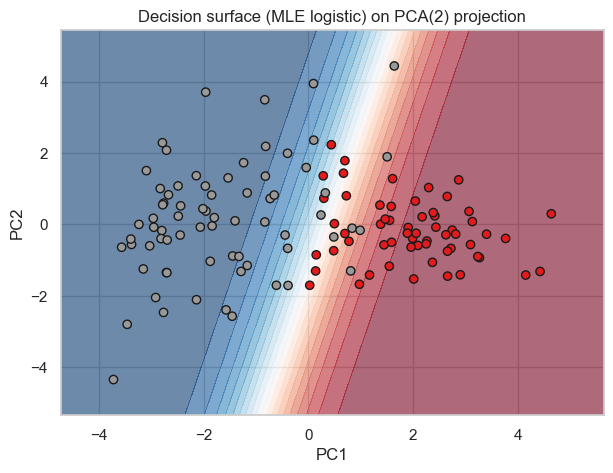

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.special import expit  # sigmoid
from time import time

sns.set(style="whitegrid", context="notebook")



In [2]:
# -------------------------
# 0. Load & prepare data
# -------------------------
wine = load_wine()
X = wine.data
y_full = wine.target

# for simplicity use binary classification: class 0 vs class 1
mask = (y_full == 0) | (y_full == 1)
X = X[mask]
y = y_full[mask]

# Standardize features
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# Add intercept column
X_design = np.hstack([np.ones((Xs.shape[0],1)), Xs])   # shape (n, d+1)

n, d = X_design.shape
print(f"Dataset: n={n} samples, d={d} parameters (including intercept)")



Dataset: n=130 samples, d=14 parameters (including intercept)


In [3]:
# -------------------------
# PART A: Metropolis MCMC
# Bayesian logistic regression:
#   y_i ~ Bernoulli(sigmoid(X_i dot beta))
# Prior: beta_j ~ Normal(0, sigma_prior^2) independent
# We sample in beta-space using random-walk Metropolis
# -------------------------

def log_prior(beta, sigma=10.0):
    # Normal(0, sigma^2)
    return -0.5 * np.sum((beta / sigma)**2) - beta.size * np.log(sigma * np.sqrt(2*np.pi))

def log_likelihood(beta, X, y):
    # vectorized stable log-likelihood for Bernoulli logistic
    xb = X.dot(beta)
    # log p = sum(y*log(sigmoid(xb)) + (1-y)*log(1-sigmoid(xb)))
    # use log-sigmoid stable formulas
    ll = np.sum(y * (-np.log1p(np.exp(-xb))) + (1-y) * (-np.log1p(np.exp(xb))))
    return ll

def log_posterior(beta, X, y, sigma_prior=10.0):
    return log_prior(beta, sigma=sigma_prior) + log_likelihood(beta, X, y)

# Sampler settings
np.random.seed(42)
n_iter = 25000      # total iterations
burn_in = 5000
thin = 5
sigma_prior = 5.0   # prior std dev
prop_sd = 0.05      # proposal SD for each component (in natural space)

# initialize at MLE from sklearn (good starting point)
clf = LogisticRegression(fit_intercept=True, C=1e6, solver='lbfgs', max_iter=1000)
clf.fit(Xs, y)
beta_init = np.concatenate([[clf.intercept_[0]], clf.coef_.ravel()])  # shape (d,)

print("Initial beta (MLE estimate):", np.round(beta_init,3))

# Random-walk Metropolis
def metropolis_rw(init_beta, X, y, n_iter, prop_sd, sigma_prior):
    d = init_beta.size
    current = init_beta.copy()
    current_logpost = log_posterior(current, X, y, sigma_prior)
    samples = np.zeros((n_iter, d))
    accepts = 0
    for i in range(n_iter):
        proposal = current + np.random.normal(0, prop_sd, size=d)
        prop_logpost = log_posterior(proposal, X, y, sigma_prior)
        log_alpha = prop_logpost - current_logpost
        if np.log(np.random.rand()) < log_alpha:
            current = proposal
            current_logpost = prop_logpost
            accepts += 1
        samples[i] = current
        if (i+1) % 5000 == 0:
            print(f"Iter {i+1}/{n_iter}, acc_rate={accepts/(i+1):.3f}")
    acc_rate = accepts / n_iter
    return samples, acc_rate

t0 = time()
samples_raw, acc_rate = metropolis_rw(beta_init, X_design, y, n_iter, prop_sd, sigma_prior)
t1 = time()
print(f"Metropolis done. Acceptance rate = {acc_rate:.3f}. Time = {t1-t0:.1f}s")

# Thin and drop burn-in
samples = samples_raw[burn_in::thin, :]
print("Posterior samples shape:", samples.shape)



Initial beta (MLE estimate): [  0.433  -9.979  -3.553  -9.16   11.072  -1.491   0.283  -3.226   1.677
   1.614  -2.46    1.011  -5.41  -15.018]
Iter 5000/25000, acc_rate=0.971
Iter 10000/25000, acc_rate=0.963
Iter 15000/25000, acc_rate=0.962
Iter 20000/25000, acc_rate=0.956
Iter 25000/25000, acc_rate=0.952
Metropolis done. Acceptance rate = 0.952. Time = 0.8s
Posterior samples shape: (4000, 14)


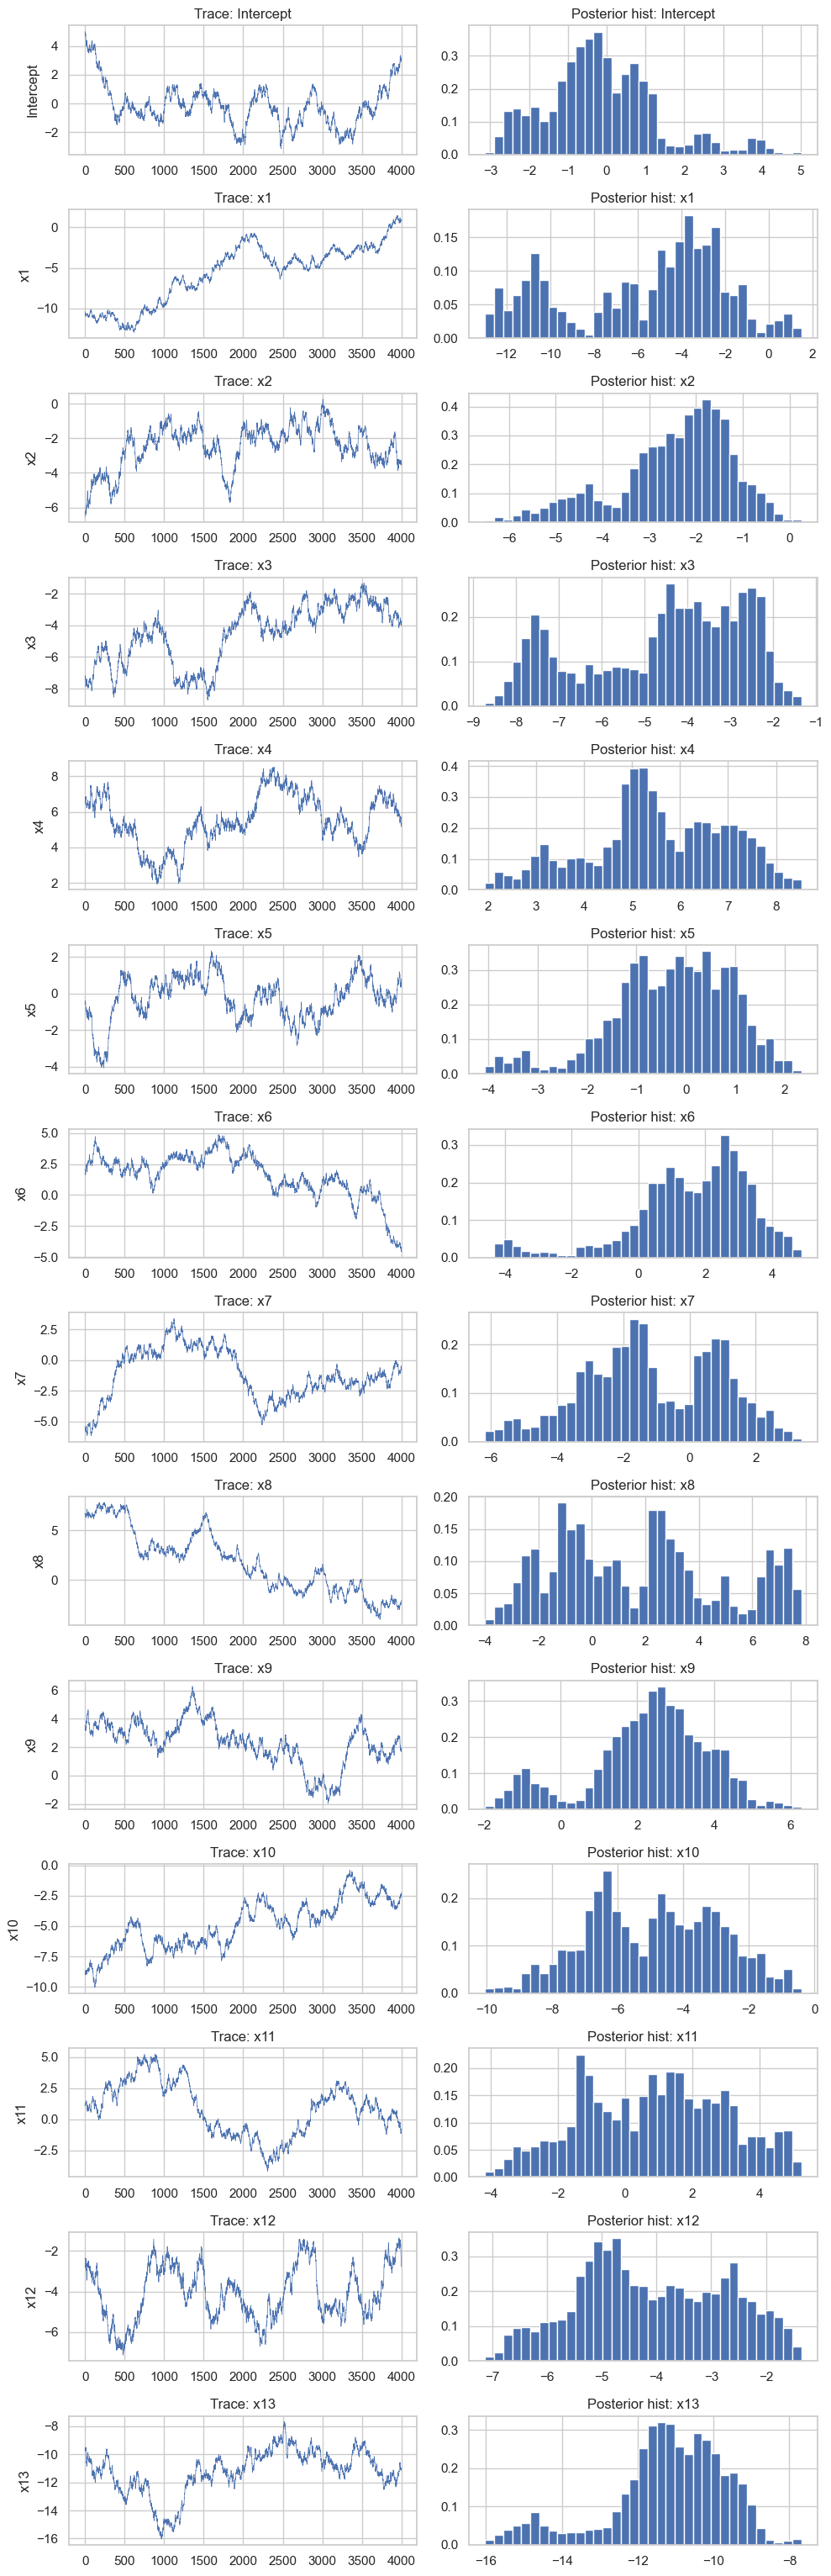


Posterior mean and sd:
        param  post_mean   post_sd
0   Intercept  -0.135516  1.452643
1          x1  -5.653987  3.658619
2          x2  -2.460135  1.232977
3          x3  -4.557170  1.860588
4          x4   5.515782  1.439649
5          x5  -0.292940  1.212944
6          x6   1.568864  1.802969
7          x7  -1.159448  2.032704
8          x8   1.799511  3.128362
9          x9   2.301435  1.568341
10        x10  -4.915732  1.999172
11        x11   0.851158  2.139242
12        x12  -4.086922  1.340147
13        x13 -11.238910  1.577045


In [4]:
# -------------------------
# Diagnostic plots: traces + histograms
# -------------------------
param_names = ["Intercept"] + [f"x{i}" for i in range(1, d)]
n_params = samples.shape[1]

fig, axes = plt.subplots(n_params, 2, figsize=(10, 2.2*n_params), sharex=False)
for j in range(n_params):
    ax_trace = axes[j,0]
    ax_hist = axes[j,1]
    ax_trace.plot(samples[:,j], lw=0.5)
    ax_trace.set_ylabel(param_names[j])
    ax_trace.set_title(f"Trace: {param_names[j]}")
    ax_hist.hist(samples[:,j], bins=35, density=True)
    ax_hist.set_title(f"Posterior hist: {param_names[j]}")
plt.tight_layout()
plt.show()

# Posterior summaries
post_mean = samples.mean(axis=0)
post_sd   = samples.std(axis=0)
summary = pd.DataFrame({"param":param_names, "post_mean":post_mean, "post_sd":post_sd})
print("\nPosterior mean and sd:")
print(summary)




Deterministic prediction accuracy using posterior-mean beta: 1.000
Mean predictive accuracy over 200 posterior draws: 0.995 (sd 0.006)


C:\Users\HomePC\AppData\Local\Temp\ipykernel_21800\316419677.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(prob_mean[y==0], label="class 0 probs (post-mean)", shade=True)
C:\Users\HomePC\AppData\Local\Temp\ipykernel_21800\316419677.py:27: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(prob_mean[y==1], label="class 1 probs (post-mean)", shade=True)


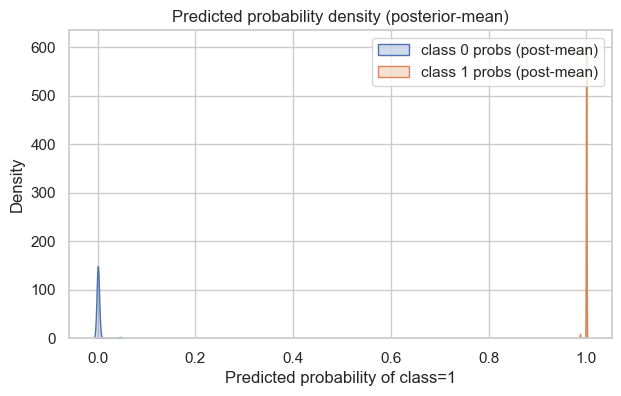

In [5]:
# -------------------------
# Posterior predictive checks
# Use posterior mean and multiple posterior draws to compute predictive probabilities
# -------------------------
def predict_prob(beta, X):
    return expit(X.dot(beta))

# predictive with posterior mean
prob_mean = predict_prob(post_mean, X_design)
pred_mean_class = (prob_mean >= 0.5).astype(int)
acc_post_mean = (pred_mean_class == y).mean()
print(f"\nDeterministic prediction accuracy using posterior-mean beta: {acc_post_mean:.3f}")

# predictive accuracy averaged over posterior draws
n_draws = 200
idx = np.random.choice(samples.shape[0], size=n_draws, replace=False)
accs = []
for ii in idx:
    probs = predict_prob(samples[ii], X_design)
    preds = (probs >= 0.5).astype(int)
    accs.append((preds == y).mean())
print(f"Mean predictive accuracy over {n_draws} posterior draws: {np.mean(accs):.3f} (sd {np.std(accs):.3f})")

# ROC-like visualization (probabilities by class)
plt.figure(figsize=(7,4))
sns.kdeplot(prob_mean[y==0], label="class 0 probs (post-mean)", shade=True)
sns.kdeplot(prob_mean[y==1], label="class 1 probs (post-mean)", shade=True)
plt.xlabel("Predicted probability of class=1")
plt.legend()
plt.title("Predicted probability density (posterior-mean)")
plt.show()



In [6]:
# -------------------------
# PART B: Deterministic model (classical MLE)
# -------------------------
# We already fitted sklearn logistic regression above on scaled features.
# Extract MLE coefficients and evaluate.
beta_mle = np.concatenate([[clf.intercept_[0]], clf.coef_.ravel()])
prob_mle = predict_prob(beta_mle, X_design)
acc_mle = ( (prob_mle >= 0.5).astype(int) == y ).mean()
print("\nClassical MLE (sklearn) accuracy:", acc_mle)

# Compare MLE vs posterior mean coefficients (table)
comp = pd.DataFrame({
    "param": param_names,
    "beta_mle": beta_mle,
    "beta_post_mean": post_mean,
    "post_sd": post_sd
})
print("\nMLE vs Posterior-mean comparison:")
print(comp.round(4))




Classical MLE (sklearn) accuracy: 1.0

MLE vs Posterior-mean comparison:
        param  beta_mle  beta_post_mean  post_sd
0   Intercept    0.4326         -0.1355   1.4526
1          x1   -9.9795         -5.6540   3.6586
2          x2   -3.5533         -2.4601   1.2330
3          x3   -9.1601         -4.5572   1.8606
4          x4   11.0724          5.5158   1.4396
5          x5   -1.4909         -0.2929   1.2129
6          x6    0.2831          1.5689   1.8030
7          x7   -3.2262         -1.1594   2.0327
8          x8    1.6768          1.7995   3.1284
9          x9    1.6141          2.3014   1.5683
10        x10   -2.4603         -4.9157   1.9992
11        x11    1.0114          0.8512   2.1392
12        x12   -5.4103         -4.0869   1.3401
13        x13  -15.0183        -11.2389   1.5770


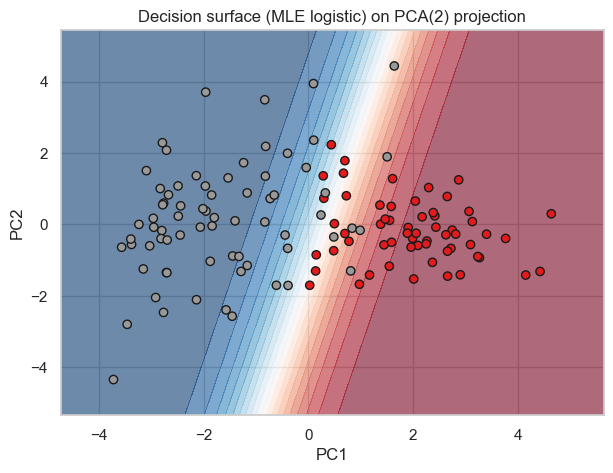

In [7]:
# -------------------------
# Optional: Visualize decision boundary on first two principal components
# -------------------------
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xs)

# Create grid, compute prob for posterior-mean beta projected onto PC space approximated:
# For a quick visualization we re-fit logistic on PC1-PC2 (deterministic) and show separation
clf2 = LogisticRegression().fit(X_pca, y)
xx, yy = np.meshgrid(np.linspace(X_pca[:,0].min()-1, X_pca[:,0].max()+1, 200),
                     np.linspace(X_pca[:,1].min()-1, X_pca[:,1].max()+1, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
probs_grid = clf2.predict_proba(grid)[:,1].reshape(xx.shape)

plt.figure(figsize=(7,5))
plt.contourf(xx, yy, probs_grid, levels=20, cmap="RdBu", alpha=0.6)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="Set1", edgecolor="k")
plt.title("Decision surface (MLE logistic) on PCA(2) projection")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


